In [4]:
# pip install psycopg2

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Importing Dependencies

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
import psycopg2
from sqlalchemy import create_engine
from tensorflow import keras
import datetime as dt



Housing Dataset
---------------


**Dataset characteristics:**

    :Number of instances: 54,670

    :Number of Attributes: 84

    :Attribute Information:
 
        -'Single_Family_Median_Typical_Home_Value' Median value of each house type
        -'One_Bedroom_Median_Typical_Home_Value' Median value of one bedroom homes over the entire dataset
        -'Two_Bedroom_Median_Typical_Home_Value' Median value of two bedroom homes over the entire dataset
        -'Three_Bedroom_Median_Typical_Home_Value' Median value of three bedroom homes over the entire dataset
        -'Four_Bedroom_Median_Typical_Home_Value' Median value of four bedroom homes over the entire dataset
        -'Five_Plus_Bedroom_Median_Typical_Home_Value' Median value of five+ bedroom homes over the entire dataset
        -'Estimated_Median_Household_Income' Median household income for the year for the city
        -'2021_estimated_population' Estimated population for the city in 2021
        -'Median_Taxes' Median taxes paid for the household in the city
        -'Median_Rent' Median rent paid in the city for each year
        -'Median_Monthly_Income' Median income divided by 12
        -'Monthly_Affordability_Limit' Based on 30% of median monthly income
        -'Year' The year each metric was observed
        -'City_[CITYNAME]' Each city encoded using OneHotEncoder

    :Missing Attribute Values: none

This dataset was obtained from zillow research data and US census data from 2011 to 2021.

The target variable for the confusion matrix is 'affordability_home_30yr_Payment_20_Perc_Down'



In [2]:
# Import the dataset from the AWS database

from config import engine_url

# Create an engine instance

alchemyEngine   = create_engine(engine_url, pool_recycle=3600);

 

# Connect to PostgreSQL server

dbConnection    = alchemyEngine.connect();

 

# Read data from PostgreSQL database table and load into a DataFrame instance

df       = pd.read_sql("select * from \"master_data_set\"", dbConnection);

 

pd.set_option('display.expand_frame_repr', False);

 

# Print the DataFrame

print(df);

 

# Close the database connection

dbConnection.close();

     Identifier  City_Rank_by_Population(2021)       State State_abbreviation         City Observation_Date  Single_Family_Median_Typical_Home_Value  One_Bedroom_Median_Typical_Home_Value  Two_Bedroom_Median_Typical_Home_Value  Three_Bedroom_Median_Typical_Home_Value  ...  affordability_3br_30yr_Payment_10_Perc_Down  affordability_3br_30yr_Payment_20_Perc_Down  affordability_4br_15yr_Payment_10_Perc_Down  affordability_4br_15yr_Payment_20_Perc_Down  affordability_4br_30yr_Payment_10_Perc_Down  affordability_4br_30yr_Payment_20_Perc_Down  affordability_5_plus_br_15yr_Payment_10_Perc_Down  affordability_5_plus_br_15yr_Payment_20_Perc_Down  affordability_5_plus_br_30yr_Payment_10_Perc_Down  affordability_5_plus_br_30yr_Payment_20_Perc_Down
0        201101                              1    New York                 NY     New York       2011-01-01                                 460824.0                               419555.5                               549450.5                           

In [3]:
df

,Identifier,City_Rank_by_Population(2021),State,State_abbreviation,City,Observation_Date,Single_Family_Median_Typical_Home_Value,One_Bedroom_Median_Typical_Home_Value,Two_Bedroom_Median_Typical_Home_Value,Three_Bedroom_Median_Typical_Home_Value,...,affordability_3br_30yr_Payment_10_Perc_Down,affordability_3br_30yr_Payment_20_Perc_Down,affordability_4br_15yr_Payment_10_Perc_Down,affordability_4br_15yr_Payment_20_Perc_Down,affordability_4br_30yr_Payment_10_Perc_Down,affordability_4br_30yr_Payment_20_Perc_Down,affordability_5_plus_br_15yr_Payment_10_Perc_Down,affordability_5_plus_br_15yr_Payment_20_Perc_Down,affordability_5_plus_br_30yr_Payment_10_Perc_Down,affordability_5_plus_br_30yr_Payment_20_Perc_Down
0,201101,1,New York,NY,New York,2011-01-01,460824.0,419555.5,549450.5,455413.0,...,0.60,0.67,0.36,0.40,0.51,0.58,0.29,0.32,0.41,0.46
1,201201,1,New York,NY,New York,2012-01-01,453166.5,421581.5,549293.0,448447.0,...,0.69,0.77,0.39,0.44,0.59,0.66,0.31,0.35,0.47,0.53
2,201301,1,New York,NY,New York,2013-01-01,467125.5,445182.5,579800.5,461446.5,...,0.66,0.74,0.38,0.43,0.56,0.63,0.30,0.34,0.44,0.50
3,201401,1,New York,NY,New York,2014-01-01,499898.0,487199.5,634870.5,493995.0,...,0.61,0.69,0.36,0.40,0.51,0.58,0.28,0.31,0.40,0.45
4,201501,1,New York,NY,New York,2015-01-01,526189.0,536285.0,689511.5,522588.5,...,0.63,0.71,0.36,0.40,0.53,0.59,0.27,0.30,0.40,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,201775,75,New Jersey,NJ,Jersey City,2017-01-01,408525.0,471067.5,537922.5,458794.5,...,0.84,0.95,0.59,0.66,0.87,0.98,0.55,0.61,0.81,0.91
777,201875,75,New Jersey,NJ,Jersey City,2018-01-01,459463.0,503269.5,568473.0,501645.0,...,0.79,0.89,0.55,0.62,0.80,0.90,0.50,0.57,0.73,0.82
778,201975,75,New Jersey,NJ,Jersey City,2019-01-01,489001.0,490562.5,566059.0,523939.5,...,0.91,1.03,0.60,0.68,0.90,1.02,0.56,0.62,0.83,0.94
779,202075,75,New Jersey,NJ,Jersey City,2020-01-01,514131.5,487710.5,570039.5,541306.0,...,0.92,1.03,0.58,0.65,0.90,1.02,0.52,0.59,0.82,0.92


In [4]:
# Create a list of targets for the neural network

columns_list = df.columns.to_list()

target_list = columns_list[45:]

target_list

['affordability_rent',
 'affordability_home_15yr_Payment_10_Perc_Down',
 'affordability_home_15yr_Payment_20_Perc_Down',
 'affordability_home_30yr_Payment_10_Perc_Down',
 'affordability_home_30yr_Payment_20_Perc_Down',
 'affordability_1br_15yr_Payment_10_Perc_Down',
 'affordability_1br_15yr_Payment_20_Perc_Down',
 'affordability_1br_30yr_Payment_10_Perc_Down',
 'affordability_1br_30yr_Payment_20_Perc_Down',
 'affordability_2br_15yr_Payment_10_Perc_Down',
 'affordability_2br_15yr_Payment_20_Perc_Down',
 'affordability_2br_30yr_Payment_10_Perc_Down',
 'affordability_2br_30yr_Payment_20_Perc_Down',
 'affordability_3br_15yr_Payment_10_Perc_Down',
 'affordability_3br_15yr_Payment_20_Perc_Down',
 'affordability_3br_30yr_Payment_10_Perc_Down',
 'affordability_3br_30yr_Payment_20_Perc_Down',
 'affordability_4br_15yr_Payment_10_Perc_Down',
 'affordability_4br_15yr_Payment_20_Perc_Down',
 'affordability_4br_30yr_Payment_10_Perc_Down',
 'affordability_4br_30yr_Payment_20_Perc_Down',
 'affordabili

In [5]:
# Change affordability to 0 or 1 in the target columns

df[target_list] = np.where(df[target_list]>=1.00,1, 0)
df

,Identifier,City_Rank_by_Population(2021),State,State_abbreviation,City,Observation_Date,Single_Family_Median_Typical_Home_Value,One_Bedroom_Median_Typical_Home_Value,Two_Bedroom_Median_Typical_Home_Value,Three_Bedroom_Median_Typical_Home_Value,...,affordability_3br_30yr_Payment_10_Perc_Down,affordability_3br_30yr_Payment_20_Perc_Down,affordability_4br_15yr_Payment_10_Perc_Down,affordability_4br_15yr_Payment_20_Perc_Down,affordability_4br_30yr_Payment_10_Perc_Down,affordability_4br_30yr_Payment_20_Perc_Down,affordability_5_plus_br_15yr_Payment_10_Perc_Down,affordability_5_plus_br_15yr_Payment_20_Perc_Down,affordability_5_plus_br_30yr_Payment_10_Perc_Down,affordability_5_plus_br_30yr_Payment_20_Perc_Down
0,201101,1,New York,NY,New York,2011-01-01,460824.0,419555.5,549450.5,455413.0,...,0,0,0,0,0,0,0,0,0,0
1,201201,1,New York,NY,New York,2012-01-01,453166.5,421581.5,549293.0,448447.0,...,0,0,0,0,0,0,0,0,0,0
2,201301,1,New York,NY,New York,2013-01-01,467125.5,445182.5,579800.5,461446.5,...,0,0,0,0,0,0,0,0,0,0
3,201401,1,New York,NY,New York,2014-01-01,499898.0,487199.5,634870.5,493995.0,...,0,0,0,0,0,0,0,0,0,0
4,201501,1,New York,NY,New York,2015-01-01,526189.0,536285.0,689511.5,522588.5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,201775,75,New Jersey,NJ,Jersey City,2017-01-01,408525.0,471067.5,537922.5,458794.5,...,0,0,0,0,0,0,0,0,0,0
777,201875,75,New Jersey,NJ,Jersey City,2018-01-01,459463.0,503269.5,568473.0,501645.0,...,0,0,0,0,0,0,0,0,0,0
778,201975,75,New Jersey,NJ,Jersey City,2019-01-01,489001.0,490562.5,566059.0,523939.5,...,0,1,0,0,0,1,0,0,0,0
779,202075,75,New Jersey,NJ,Jersey City,2020-01-01,514131.5,487710.5,570039.5,541306.0,...,0,1,0,0,0,1,0,0,0,0


In [6]:
# Encode each city into its own column

enc = OneHotEncoder(sparse=False)
encode_df = pd.DataFrame(enc.fit_transform(df[['City']]))
encode_df.columns=enc.get_feature_names_out(['City'])

In [7]:
# Merge the encoded city columns and drop the City column

df = df.merge(encode_df, left_index=True, right_index=True)
df.drop(columns=['City'], inplace=True)

In [8]:
# Change the observation date to year

df['Observation_Date'] = pd.to_datetime(df['Observation_Date'])
df['Year'] = df['Observation_Date'].dt.year

In [9]:
# Create a dataset for 2021 to test the model's ability to predict affordability

df_eval = df.loc[df['Year']==2021]
df_eval

,Identifier,City_Rank_by_Population(2021),State,State_abbreviation,Observation_Date,Single_Family_Median_Typical_Home_Value,One_Bedroom_Median_Typical_Home_Value,Two_Bedroom_Median_Typical_Home_Value,Three_Bedroom_Median_Typical_Home_Value,Four_Bedroom_Median_Typical_Home_Value,...,City_Santa Ana,City_Seattle,City_Stockton,City_Tampa,City_Tucson,City_Tulsa,City_Virginia Beach,City_Washington,City_Wichita,Year
10,202101,1,New York,NY,2021-01-01,706417.0,603709.0,751189.0,690397.5,829040.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021
21,202102,2,California,CA,2021-01-01,937656.5,575026.0,746089.5,860336.5,1066739.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021
32,202103,3,Illinois,IL,2021-01-01,282580.0,236544.5,284521.5,291592.0,346520.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021
43,202104,4,Texas,TX,2021-01-01,229725.5,132536.0,168663.5,210146.0,276587.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021
54,202105,5,Arizona,AZ,2021-01-01,359291.5,216523.0,277632.0,340718.0,428991.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,202171,71,Nebraska,NE,2021-01-01,239984.0,202191.0,192750.0,240544.5,326178.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021
747,202172,72,Texas,TX,2021-01-01,418720.0,201140.5,291360.0,343630.0,460291.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021
758,202173,73,Alaska,AK,2021-01-01,386293.5,182718.5,233835.5,348141.5,439046.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021
769,202174,74,North Carolina,NC,2021-01-01,314496.5,211638.0,229229.5,292391.5,406237.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021


In [10]:
# Create a dataset from 2011-2020 to train the neural network

df_train= df.loc[df['Year']!=2021]
df_train

,Identifier,City_Rank_by_Population(2021),State,State_abbreviation,Observation_Date,Single_Family_Median_Typical_Home_Value,One_Bedroom_Median_Typical_Home_Value,Two_Bedroom_Median_Typical_Home_Value,Three_Bedroom_Median_Typical_Home_Value,Four_Bedroom_Median_Typical_Home_Value,...,City_Santa Ana,City_Seattle,City_Stockton,City_Tampa,City_Tucson,City_Tulsa,City_Virginia Beach,City_Washington,City_Wichita,Year
0,201101,1,New York,NY,2011-01-01,460824.0,419555.5,549450.5,455413.0,532583.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011
1,201201,1,New York,NY,2012-01-01,453166.5,421581.5,549293.0,448447.0,526229.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012
2,201301,1,New York,NY,2013-01-01,467125.5,445182.5,579800.5,461446.5,543111.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013
3,201401,1,New York,NY,2014-01-01,499898.0,487199.5,634870.5,493995.0,588659.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
4,201501,1,New York,NY,2015-01-01,526189.0,536285.0,689511.5,522588.5,628622.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,201675,75,New Jersey,NJ,2016-01-01,365580.5,433664.0,495381.5,410903.0,403386.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016
776,201775,75,New Jersey,NJ,2017-01-01,408525.0,471067.5,537922.5,458794.5,445592.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017
777,201875,75,New Jersey,NJ,2018-01-01,459463.0,503269.5,568473.0,501645.0,497800.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018
778,201975,75,New Jersey,NJ,2019-01-01,489001.0,490562.5,566059.0,523939.5,529699.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019


In [11]:
# Creating a list of features for the neural network

columns_list = df.columns.tolist()
columns_list

remove_list = ['Identifier',
 'City_Rank_by_Population(2021)',
 'State',
 'State_abbreviation',
 'Observation_Date',
 '2020_census',
 'AnnualAverageRate15Year',
 'AnnualAverageRate30Year',
 'home_15yr_Payment_10_Perc_Down',
 'home_15yr_Payment_20_Perc_Down',
 'home_30yr_Payment_10_Perc_Down',
 'home_30yr_Payment_20_Perc_Down',
 '1br_15yr_Payment_10_Perc_Down',
 '1br_15yr_Payment_20_Perc_Down',
 '1br_30yr_Payment_10_Perc_Down',
 '1br_30yr_Payment_20_Perc_Down',
 '2br_15yr_Payment_10_Perc_Down',
 '2br_15yr_Payment_20_Perc_Down',
 '2br_30yr_Payment_10_Perc_Down',
 '2br_30yr_Payment_20_Perc_Down',
 '3br_15yr_Payment_10_Perc_Down',
 '3br_15yr_Payment_20_Perc_Down',
 '3br_30yr_Payment_10_Perc_Down',
 '3br_30yr_Payment_20_Perc_Down',
 '4br_15yr_Payment_10_Perc_Down',
 '4br_15yr_Payment_20_Perc_Down',
 '4br_30yr_Payment_10_Perc_Down',
 '4br_30yr_Payment_20_Perc_Down',
 '5_plus_br_15yr_Payment_10_Perc_Down',
 '5_plus_br_15yr_Payment_20_Perc_Down',
 '5_plus_br_30yr_Payment_10_Perc_Down',
 '5_plus_br_30yr_Payment_20_Perc_Down',
 'affordability_rent',
 'affordability_home_15yr_Payment_10_Perc_Down',
 'affordability_home_15yr_Payment_20_Perc_Down',
 'affordability_home_30yr_Payment_10_Perc_Down',
 'affordability_home_30yr_Payment_20_Perc_Down',
 'affordability_1br_15yr_Payment_10_Perc_Down',
 'affordability_1br_15yr_Payment_20_Perc_Down',
 'affordability_1br_30yr_Payment_10_Perc_Down',
 'affordability_1br_30yr_Payment_20_Perc_Down',
 'affordability_2br_15yr_Payment_10_Perc_Down',
 'affordability_2br_15yr_Payment_20_Perc_Down',
 'affordability_2br_30yr_Payment_10_Perc_Down',
 'affordability_2br_30yr_Payment_20_Perc_Down',
 'affordability_3br_15yr_Payment_10_Perc_Down',
 'affordability_3br_15yr_Payment_20_Perc_Down',
 'affordability_3br_30yr_Payment_10_Perc_Down',
 'affordability_3br_30yr_Payment_20_Perc_Down',
 'affordability_4br_15yr_Payment_10_Perc_Down',
 'affordability_4br_15yr_Payment_20_Perc_Down',
 'affordability_4br_30yr_Payment_10_Perc_Down',
 'affordability_4br_30yr_Payment_20_Perc_Down',
 'affordability_5_plus_br_15yr_Payment_10_Perc_Down',
 'affordability_5_plus_br_15yr_Payment_20_Perc_Down',
 'affordability_5_plus_br_30yr_Payment_10_Perc_Down',
 'affordability_5_plus_br_30yr_Payment_20_Perc_Down']

for metric in remove_list:
    columns_list.remove(metric)

columns_list

# x_columns = ['Year','Estimated_Median_Household_Income', '2021_estimated_population', '2020_census', 'Median_Taxes', 'Median_Rent', 'AnnualAverageRate30Year','Median_Monthly_Income','Monthly_Affordability_Limit'] 
# 'home_30yr_Payment_20_Perc_Down', '1br_30yr_Payment_20_Perc_Down', '2br_30yr_Payment_20_Perc_Down', 
# '3br_30yr_Payment_20_Perc_Down', '4br_30yr_Payment_20_Perc_Down', '5_plus_br_30yr_Payment_20_Perc_Down', 'Median_Monthly_Income', 'Monthly_Affordability_Limit'




# y=df['affordability_home_30yr_Payment_20_Perc_Down']

['Single_Family_Median_Typical_Home_Value',
 'One_Bedroom_Median_Typical_Home_Value',
 'Two_Bedroom_Median_Typical_Home_Value',
 'Three_Bedroom_Median_Typical_Home_Value',
 'Four_Bedroom_Median_Typical_Home_Value',
 'Five_Plus_Bedroom_Median_Typical_Home_Value',
 'Estimated_Median_Household_Income',
 '2021_estimated_population',
 'Median_Taxes',
 'Median_Rent',
 'Median_Monthly_Income',
 'Monthly_Affordability_Limit',
 'City_Albuquerque',
 'City_Anaheim',
 'City_Anchorage',
 'City_Arlington',
 'City_Atlanta',
 'City_Aurora',
 'City_Austin',
 'City_Bakersfield',
 'City_Baltimore',
 'City_Boston',
 'City_Charlotte',
 'City_Chicago',
 'City_Cincinnati',
 'City_Cleveland',
 'City_Colorado Springs',
 'City_Columbus',
 'City_Corpus Christi',
 'City_Dallas',
 'City_Denver',
 'City_Detroit',
 'City_Durham',
 'City_El Paso',
 'City_Fort Worth',
 'City_Fresno',
 'City_Greensboro',
 'City_Henderson',
 'City_Houston',
 'City_Indianapolis',
 'City_Irvine',
 'City_Jacksonville',
 'City_Jersey City',

In [12]:
# Determining input dimensions
len(columns_list)

84

In [13]:
# Creating the feature group
X = df_train[columns_list]

In [15]:
# Testing the features in a test, train split group

for target in target_list:
    y=df_train[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    nn_model = tf.keras.models.Sequential()
    nn_model.add(tf.keras.layers.Dense(units=100, activation="relu", input_dim=84))
    nn_model.add(tf.keras.layers.Dense(units=50, activation="relu"))
    nn_model.add(tf.keras.layers.Dense(units=25, activation="relu"))
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the Sequential model together and customize metrics
    nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


    # Train the model
    fit_model = nn_model.fit(X_train_scaled, y_train, epochs=25)

    # Evaluate the model using the test data
    model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/25
17/17 [==============================] - 0s 997us/step - loss: 0.8307 - accuracy: 0.5132
Epoch 2/25
17/17 [==============================] - 0s 1ms/step - loss: 0.2466 - accuracy: 0.9398
Epoch 3/25
17/17 [==============================] - 0s 1ms/step - loss: 0.1470 - accuracy: 0.9398
Epoch 4/25
17/17 [==============================] - 0s 997us/step - loss: 0.0987 - accuracy: 0.9530
Epoch 5/25
17/17 [==============================] - 0s 1ms/step - loss: 0.0717 - accuracy: 0.9831
Epoch 6/25
17/17 [==============================] - 0s 935us/step - loss: 0.0540 - accuracy: 0.9868
Epoch 7/25
17/17 [==============================] - 0s 997us/step - loss: 0.0437 - accuracy: 0.9868
Epoch 8/25
17/17 [==============================] - 0s 935us/step - loss: 0.0379 - accuracy: 0.9868
Epoch 9/25
17/17 [==============================] - 0s 935us/step - loss: 0.0317 - accuracy: 0.9868
Epoch 10/25
17/17 [==============================] - 0s 1ms/step - loss: 0.0288 - accuracy: 0.9868
Epoch 1

Make Model from 2011-2020

In [16]:
# Scaling the data from 2011 to 2020

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)


In [17]:
#Creating data models for each target based on the complete data from 2011 to 2020

for target in target_list:
    y=df_train[target]

    #Build Dense layers for neural network
    nn_model = tf.keras.models.Sequential()
    nn_model.add(tf.keras.layers.Dense(units=100, activation="relu", input_dim=84))
    nn_model.add(tf.keras.layers.Dense(units=50, activation="relu"))
    nn_model.add(tf.keras.layers.Dense(units=25, activation="relu"))
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the Sequential model together and customize metrics
    nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


    # Train the model
    fit_model = nn_model.fit(X_scaled, y, epochs=25)

    # Evaluate the model
    model_loss, model_accuracy = nn_model.evaluate(X_scaled, y ,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
    print(nn_model.summary())
    nn_model.save("./Models/"+ target +"_model.h5")


Epoch 1/25
23/23 [==============================] - 1s 1ms/step - loss: 0.3199 - accuracy: 0.9366
Epoch 2/25
23/23 [==============================] - 0s 1ms/step - loss: 0.1176 - accuracy: 0.9507
Epoch 3/25
23/23 [==============================] - 0s 952us/step - loss: 0.0621 - accuracy: 0.9831
Epoch 4/25
23/23 [==============================] - 0s 1ms/step - loss: 0.0421 - accuracy: 0.9859
Epoch 5/25
23/23 [==============================] - 0s 1ms/step - loss: 0.0319 - accuracy: 0.9859
Epoch 6/25
23/23 [==============================] - 0s 1ms/step - loss: 0.0302 - accuracy: 0.9859
Epoch 7/25
23/23 [==============================] - 0s 997us/step - loss: 0.0285 - accuracy: 0.9873
Epoch 8/25
23/23 [==============================] - 0s 1ms/step - loss: 0.0277 - accuracy: 0.9873
Epoch 9/25
23/23 [==============================] - 0s 997us/step - loss: 0.0250 - accuracy: 0.9873
Epoch 10/25
23/23 [==============================] - 0s 1ms/step - loss: 0.0265 - accuracy: 0.9873
Epoch 11/25
2

In [18]:
# Evaluating the last model created

y_eval = pd.DataFrame(nn_model.predict(df_eval[columns_list]))
y_eval.value_counts()

3/3 [==============================] - 0s 998us/step


0.0    71
dtype: int64

In [14]:
# Load specific model
model = keras.models.load_model('./Models/affordability_home_30yr_Payment_20_Perc_Down_model.h5')


In [15]:
# Scale evaluation data

X = df_eval[columns_list]
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [16]:
# Predict the affordability using the chosen model

y_eval = pd.DataFrame(model.predict(X_scaled))
y_eval.value_counts()

3/3 [==============================] - 0s 1ms/step


9.999812e-01    3
5.008881e-07    1
9.999697e-01    1
9.999777e-01    1
9.999763e-01    1
               ..
9.999219e-01    1
9.999271e-01    1
9.999295e-01    1
9.999316e-01    1
9.999968e-01    1
Length: 69, dtype: int64

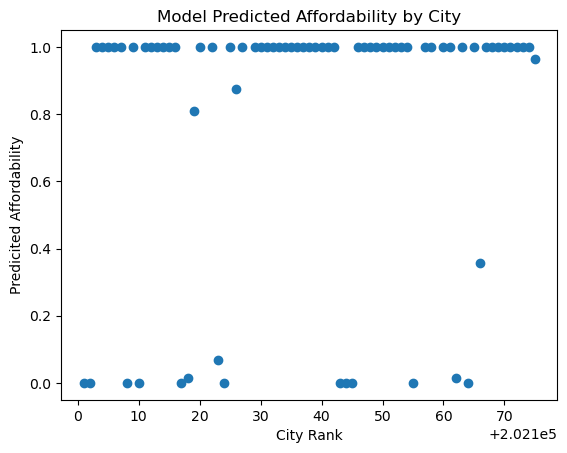

<Figure size 2000x1000 with 0 Axes>

In [17]:
# Plot the affordability by city

plt.scatter(df_eval["Identifier"], y_eval)
plt.title("Model Predicted Affordability by City")
plt.xlabel("City Rank")
plt.ylabel("Predicited Affordability")
fig1 = plt.figure(figsize=(20,10))
fig1.savefig('./Models/y_eval.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# Create a predictions list
predictions = y_eval.values

In [19]:
# Add model predictions to the evaluation dataset
df_eval['Predictions'] = predictions

C:\Users\mattw\AppData\Local\Temp\ipykernel_29908\78421546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval['Predictions'] = predictions


In [20]:
df_eval

,Identifier,City_Rank_by_Population(2021),State,State_abbreviation,Observation_Date,Single_Family_Median_Typical_Home_Value,One_Bedroom_Median_Typical_Home_Value,Two_Bedroom_Median_Typical_Home_Value,Three_Bedroom_Median_Typical_Home_Value,Four_Bedroom_Median_Typical_Home_Value,...,City_Seattle,City_Stockton,City_Tampa,City_Tucson,City_Tulsa,City_Virginia Beach,City_Washington,City_Wichita,Year,Predictions
10,202101,1,New York,NY,2021-01-01,706417.0,603709.0,751189.0,690397.5,829040.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,0.000436
21,202102,2,California,CA,2021-01-01,937656.5,575026.0,746089.5,860336.5,1066739.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,0.000030
32,202103,3,Illinois,IL,2021-01-01,282580.0,236544.5,284521.5,291592.0,346520.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,0.999976
43,202104,4,Texas,TX,2021-01-01,229725.5,132536.0,168663.5,210146.0,276587.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,0.999956
54,202105,5,Arizona,AZ,2021-01-01,359291.5,216523.0,277632.0,340718.0,428991.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,0.999978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,202171,71,Nebraska,NE,2021-01-01,239984.0,202191.0,192750.0,240544.5,326178.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,0.999982
747,202172,72,Texas,TX,2021-01-01,418720.0,201140.5,291360.0,343630.0,460291.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,0.999958
758,202173,73,Alaska,AK,2021-01-01,386293.5,182718.5,233835.5,348141.5,439046.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,0.999957
769,202174,74,North Carolina,NC,2021-01-01,314496.5,211638.0,229229.5,292391.5,406237.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,0.999917


In [21]:
# Change the raw predicted values to match formatting of actual

df_eval['Predictions'] = np.where(df_eval["Predictions"]>=0.5, 1, 0)


df_eval['affordability_home_30yr_Payment_20_Perc_Down'].value_counts()

C:\Users\mattw\AppData\Local\Temp\ipykernel_29908\2248695812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval['Predictions'] = np.where(df_eval["Predictions"]>=0.5, 1, 0)


1    56
0    15
Name: affordability_home_30yr_Payment_20_Perc_Down, dtype: int64

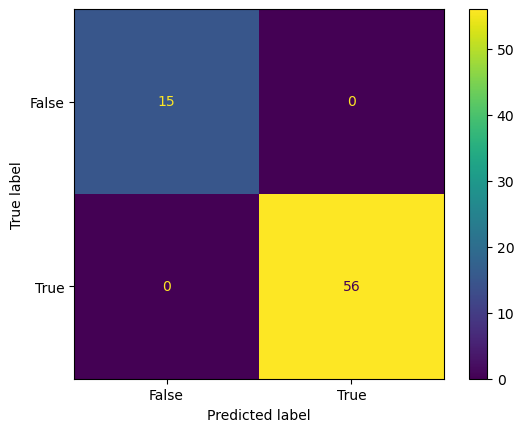

In [22]:
# Confusion Matrix

actual = df_eval['affordability_home_30yr_Payment_20_Perc_Down']
predicted = df_eval['Predictions']

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 

In [23]:
# Metrics Calculation
Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted)
Sensitivity_recall = metrics.recall_score(actual, predicted)
Specificity = metrics.recall_score(actual, predicted, pos_label=0)
F1_score = metrics.f1_score(actual, predicted) 

print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score}) 

{'Accuracy': 1.0, 'Precision': 1.0, 'Sensitivity_recall': 1.0, 'Specificity': 1.0, 'F1_score': 1.0}
